# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, I will use my trained model to generate captions for images in the test dataset.

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

As I did in the previous notebook, I define a Transform object to feed into the constructor for my Data Loader.  However, unlike in the previous notebook, here I identify the images and captions set aside for testing in my dataset as the contents of the Data Loader.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


The cell below illustrates an image from the test dataset prior to evaluation by the model.

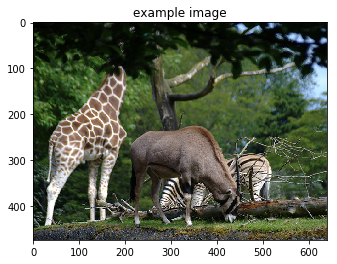

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

The following cell instructs the notebook to test the model using a GPU...

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<a id='step3'></a>
## Step 3: Run the Models

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
# embed_size is the size of the linear feature vector from the CNN
# embed_size will also be the size of the input vector into the RNN
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(8855, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=8855, bias=True)
)

## Step 4: Locate the Caption Generated for the Image in Step 1

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print(type(output))
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
# output from decoder will be integer used as key value to find word in vocab
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

<class 'list'>
example output: [0, 3, 3140, 13, 3983, 170, 77, 3, 204, 18, 1, 1, 18, 1, 1, 1, 18, 1, 1, 1]


In [6]:
for item in output:
    print(data_loader.dataset.vocab.idx2word[item])

<start>
a
herd
of
sheep
standing
in
a
field
.
<end>
<end>
.
<end>
<end>
<end>
.
<end>
<end>
<end>


<a id='step4'></a>
## Step 5: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [7]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = " "
    for item in output[1:]:
        if item != 1:
            sentence += " " + data_loader.dataset.vocab.idx2word[item]
        else:
            break
    
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  The output reflects my model's attempt to describe the content of the test image after training for only 3 Epochs...

In [8]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence:   a herd of sheep standing in a field .


<a id='step5'></a>
## Step 6: Generate Predictions!

Use Udacity-defined <em>"get_predictions()"</em> function to loop over images in the test dataset and print my model's predicted caption.

In [9]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

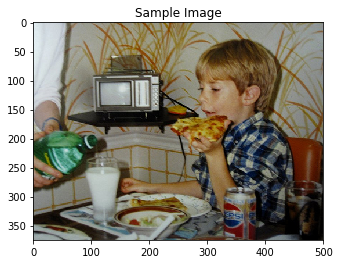

  a man is sitting at a table with a cake .


In [10]:
get_prediction()

### The model performed well!

The next two cells illustrate examples where the model generated a caption for an image within a reasonable degree of coherence.

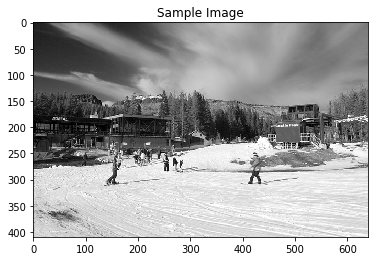

  a man on a snowboard on a snowy slope .


In [14]:
get_prediction()

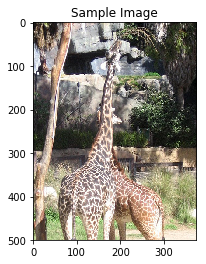

  a giraffe standing in a field with a tree .


In [18]:
get_prediction()

### The model could have performed better ...

The next two cells illustrate examples when the model did not generate captions for images at a level accurate enough to be of use to humans.

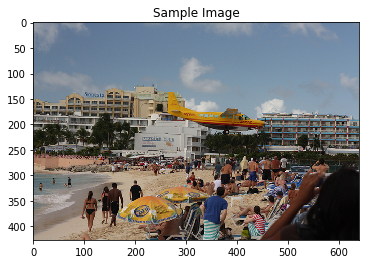

  a group of people standing in a field .


In [21]:
get_prediction()

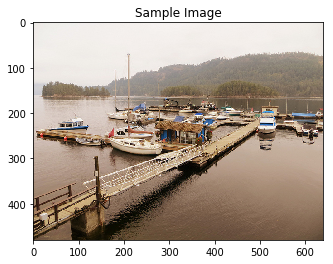

  a large boat is flying in the sky .


In [26]:
get_prediction()

## Conclusion:

Because I only trained my model for 3 epochs, while most reasonably tuned image-caption-generating models train for days, I expected an error rate of no better than 50%.  However, by using the ResNET50 architecture for my CNN, tweaking its final layer to reflect my training data, and training an RNN from scratch, I found an acceptable balance between training-time and performance to satisfy the criteria for the Udacity assignment.  

To justify this conclusion I used as evidence the two images shown above which illustrate examples of my model's inaccuracy.  Though the captions generated for the images by my model are not entirely accurate, they demonstrate a signifcant enough coherence to refute random guessing.  For example, the first incorrectly captioned image does show people gathered.  They are on a beach, however, and not in a field.  The second image correctly identifies boats, but it mislabels sky for water.  The relative accuracy of these captions compared to randomly generated captions leads me to believe the architecture of my model has within it the capacity for increased accuracy given the required resources for sufficient training.